### **Dataset**

In [135]:
import pandas as pd
df = pd.read_csv('/Users/macvision/Desktop/EcodeCamp/stock_details_5_years.csv') 
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


#### **Stock Price Prediction on Yahoo Finance Data**

### **DataPreprocessing**

In [136]:
print(df.isnull().sum()) 
print() 
print(df.info())  # for checking datatypes  
print()
print(df.columns) # Columns in the dataset 

# -------------------------- 
# 0   Date          602962 non-null  object  (This row is object, and has to be seperate in yy/mm/dd)

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Company         0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602962 entries, 0 to 602961
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          602962 non-null  object 
 1   Open          602962 non-null  float64
 2   High          602962 non-null  float64
 3   Low           602962 non-null  float64
 4   Close         602962 non-null  float64
 5   Volume        602962 non-null  int64  
 6   Dividends     602962 non-null  float64
 7   Stock Splits  602962 non-null  float64
 8   Company       602962 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB
None

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Company'],
      dtype='object')


In [137]:
# Convert the 'Date' column to string first to handle non-string entries
df['Date'] = df['Date'].astype(str)

# Remove the time and timezone part (keep only the date)
df['Date'] = df['Date'].str.split(' ').str[0]

# Convert the cleaned 'Date' column to datetime, handling any errors
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract year, month, and day only if conversion was successful
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [138]:
df.head() 
# Year / Month / Day in a seperate columns

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company,year,month,day
0,2018-11-29,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL,2018,11,29
1,2018-11-29,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT,2018,11,29
2,2018-11-29,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL,2018,11,29
3,2018-11-29,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN,2018,11,29
4,2018-11-29,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA,2018,11,29


In [139]:
# Remove Date column because yy/mm/day has extracted
df.drop(columns='Date', axis = 1, inplace = True) 

In [140]:
# For the analysis perspective no need to be remove for checking combinations
# I will Remove Company column for now because I want to train a simple LSTM model
df.drop(columns='Company', axis = 1, inplace = True)

In [141]:
# spliting X and Y 
x = df[['Open', 'High', 'Low', 'Volume']] 
y = df['Close']

In [142]:
from sklearn.preprocessing import StandardScaler
# Normalize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x) 
 
Y = y.values

In [160]:
# Function to create sequences 
import numpy as np
def create_sequences(data, target, time_step=1):
    X_seq, y_seq = [], []
    for i in range(len(data) - time_step):
        X_seq.append(data[i:(i + time_step)])
        y_seq.append(target[i + time_step])  # Predicting the next value of 'Close'
    return np.array(X_seq), np.array(y_seq)

# Set time_step (e.g., using the last 3 days to predict the next day)
time_step = 

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, Y, time_step)

# Reshape input to be [samples, time steps, features]
X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], X_seq.shape[2])  # (samples, time_steps, features)

# Display shapes
print("X shape:", X_seq.shape)  # (samples, time_steps, features)
print("y shape:", y_seq.shape)   # (samples,)

SyntaxError: invalid syntax (100519023.py, line 11)

In [144]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))  # Increased units
    model.add(Dropout(0.3))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(50))  # Increased units in Dense layer
    model.add(Dense(1))  # Output layer for regression
    return model

In [145]:
# Create the model
input_shape = (X_seq.shape[1], X_seq.shape[2])  # (time_steps, features)
model = create_lstm_model(input_shape)

# Display the model summary
model.summary();

/Users/macvision/umer_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 2, 100)         │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,501 (498.05 KB)

 Trainable params: 127,501 (498.05 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')



In [147]:
# Use only the first 25% of the data for faster training
X_train_subset = X_seq[:int(0.2 * len(X_seq))]
y_train_subset = y_seq[:int(0.2 * len(y_seq))] 
# Fit the model to the training data

In [152]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_subset, y_train_subset))
train_dataset = train_dataset.shuffle(buffer_size=512).batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Use the dataset in model training
history = model.fit(train_dataset, epochs=10)

Epoch 1/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 30237.0605
Epoch 2/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 30277.8242
Epoch 3/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 30326.0195
Epoch 4/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 30345.5508
Epoch 5/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 30347.7793
Epoch 6/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 30298.8691
Epoch 7/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 30377.2051
Epoch 8/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 30315.8633
Epoch 9/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 30183.6895
Epoch 10/10
1885/1885 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 30300.5566


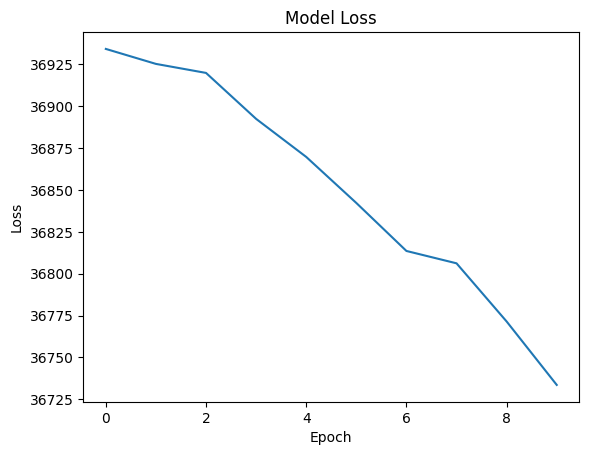

In [154]:
# Optional: Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [155]:
df.head(

)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,year,month,day
0,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,2018,11,29
1,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,2018,11,29
2,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,2018,11,29
3,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,2018,11,29
4,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,2018,11,29


In [158]:
input_data = np.array([[43.829761, 43.863354, 42.639594, 167080000]])  # Example input

# Make predictions
predictions = model.predict(input_data)

# Print the predictions
print("Predicted Output:", predictions)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(1, 4), dtype=float32). Expected shape (None, 2, 4), but input has incompatible shape (1, 4)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 4), dtype=float32)
  • training=False
  • mask=None